# Fetal Health Classification

Uterine contractions and fetal heart rate are monitored by cardiotocography (CTG). This makes it possible to monitor the health of fetus and detect fetal distress early. I will be creating a model to classify the outcome of CTG which had already been classified by expert obstetrician into three classes – 

1. Normal
2. Suspect
3. Pathological

# Libraries and Dataset Import

In [36]:
#Import libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Import Dataset
dataset = pd.read_csv('fetal_health.csv')

# Data Understanding

In [3]:
#Look at Dataset
dataset.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [4]:
#Column names
dataset.columns

Index(['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency',
       'fetal_health'],
      dtype='object')

In [5]:
#Data Type
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [6]:
#Check total rows and columns
dataset.shape

(2126, 22)

In [7]:
#Check missing values
dataset.isna().sum()

baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
histogram_mode                          

In [8]:
#Check duplicate records
dataset.duplicated().sum()

13

1. There are 2126 records with 21 variables to determine the output (fetal_health). 
2. There are no missing values
3. There are 13 duplicate values

# EDA

Text(0.5, 1.0, 'Fetal Health Count')

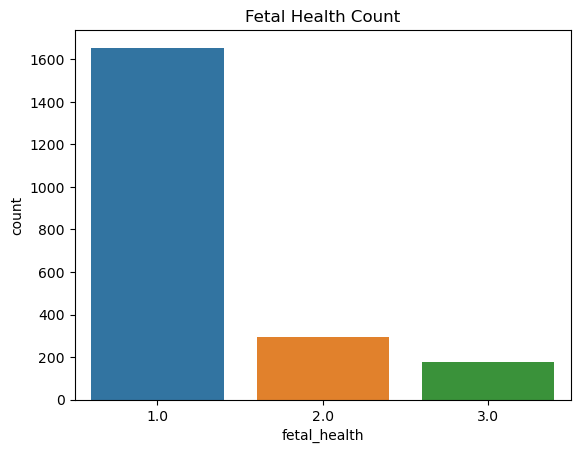

In [9]:
#fetal_health distribution
sns.countplot(x = "fetal_health", data = dataset)
plt.title('Fetal Health Count')

Dataset is imbalanced which may affect the prediction and accuracy of our outcome and model.

In [10]:
#Value count of each prediction class
print('fetal_health count in different classes:')
dataset.loc[:,"fetal_health"].value_counts()

fetal_health count in different classes:


1.0    1655
2.0     295
3.0     176
Name: fetal_health, dtype: int64

<AxesSubplot:>

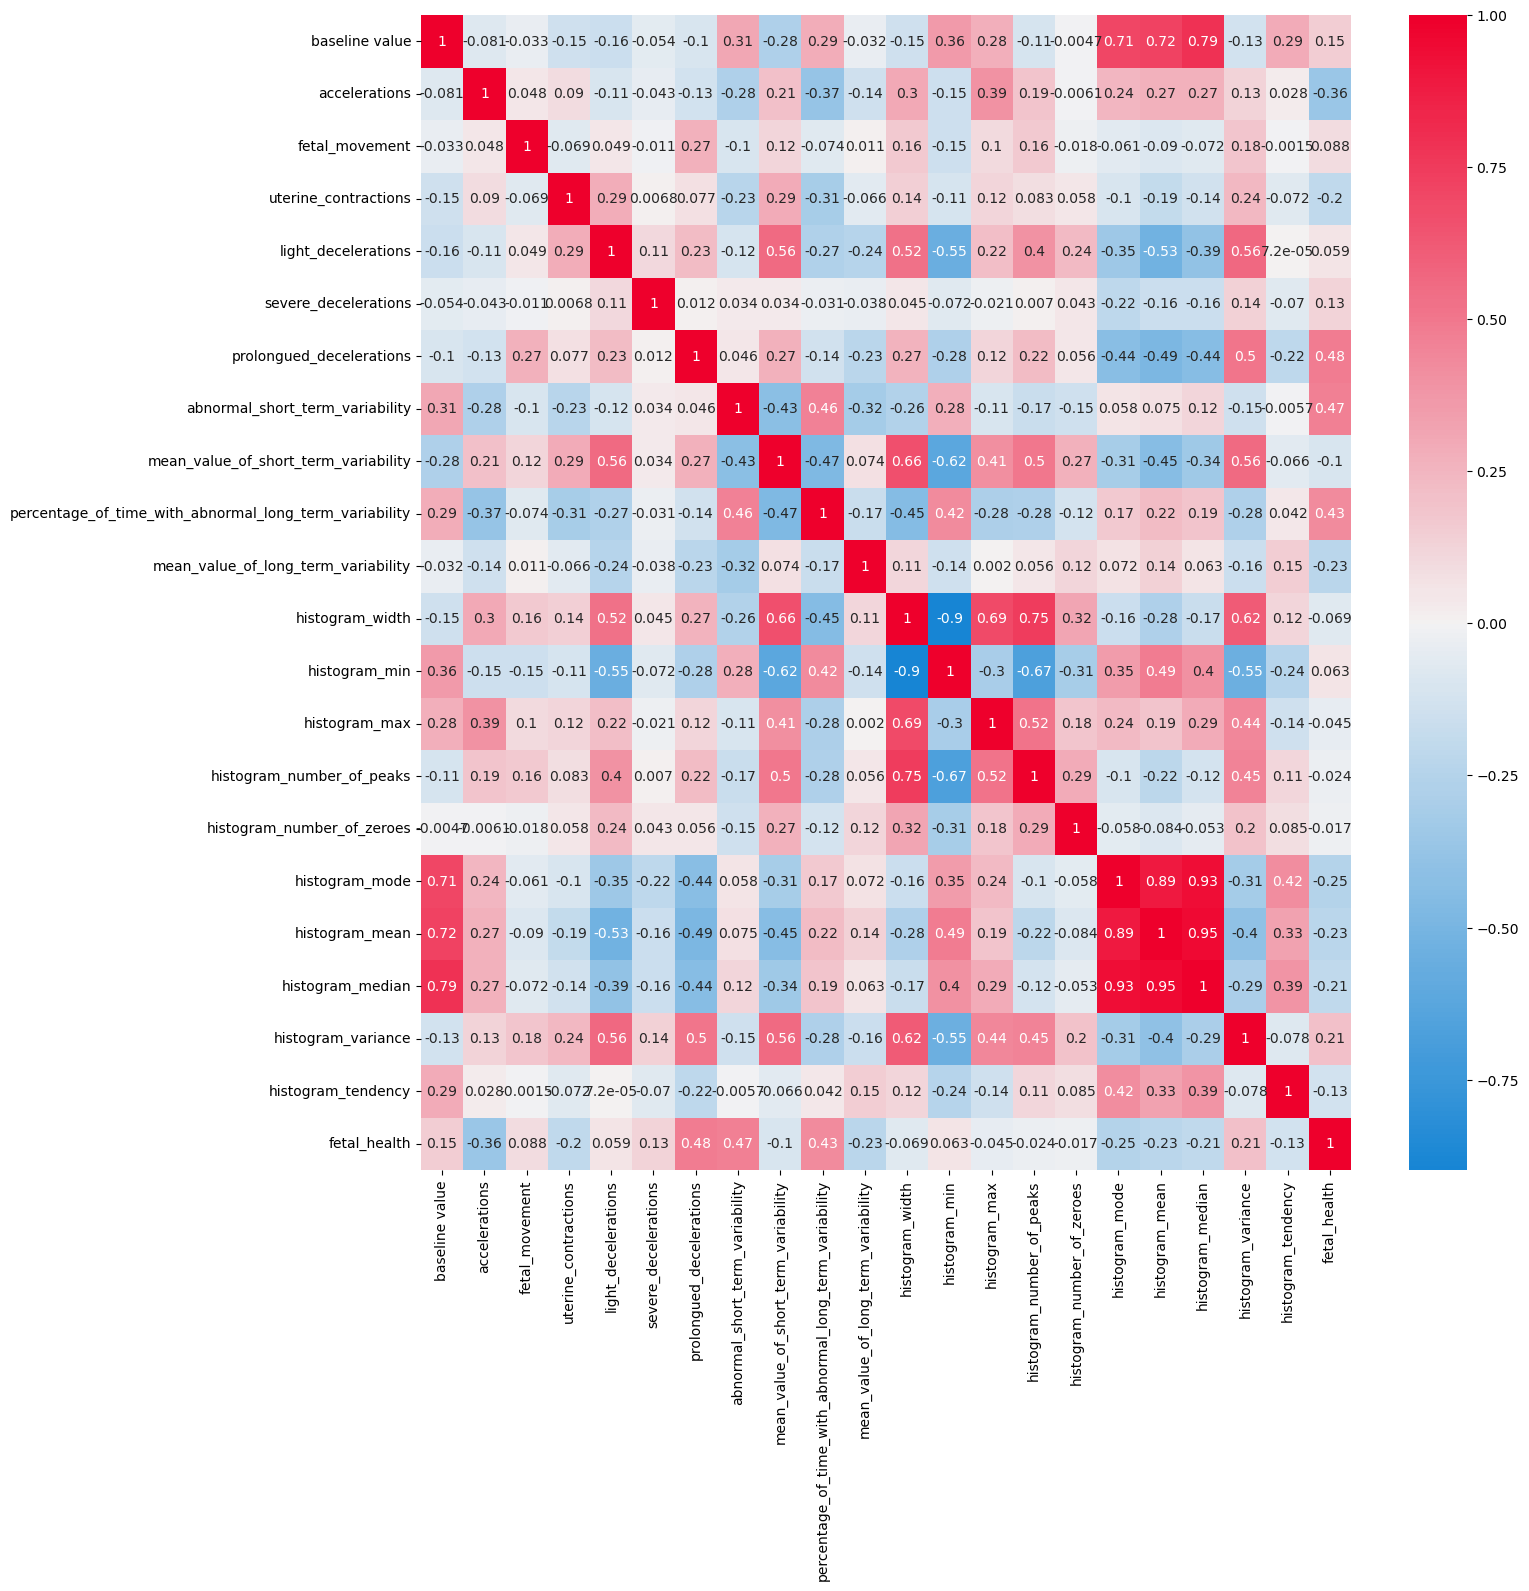

In [11]:
#Visualise correlation using heatmap for numerical values
plt.figure(figsize=(15,15))
cmap = sns.diverging_palette(250, 10, s=100, l=50, n=2, as_cmap=True)
sns.heatmap(dataset.corr(),annot=True, cmap=cmap, center=0)

According to the below heatmap, it seems like prolongued_decelerations, abnormal_short_term_variability and percentage_of_time_with_abnormal_long_term_variability has high correlation with fetal_health

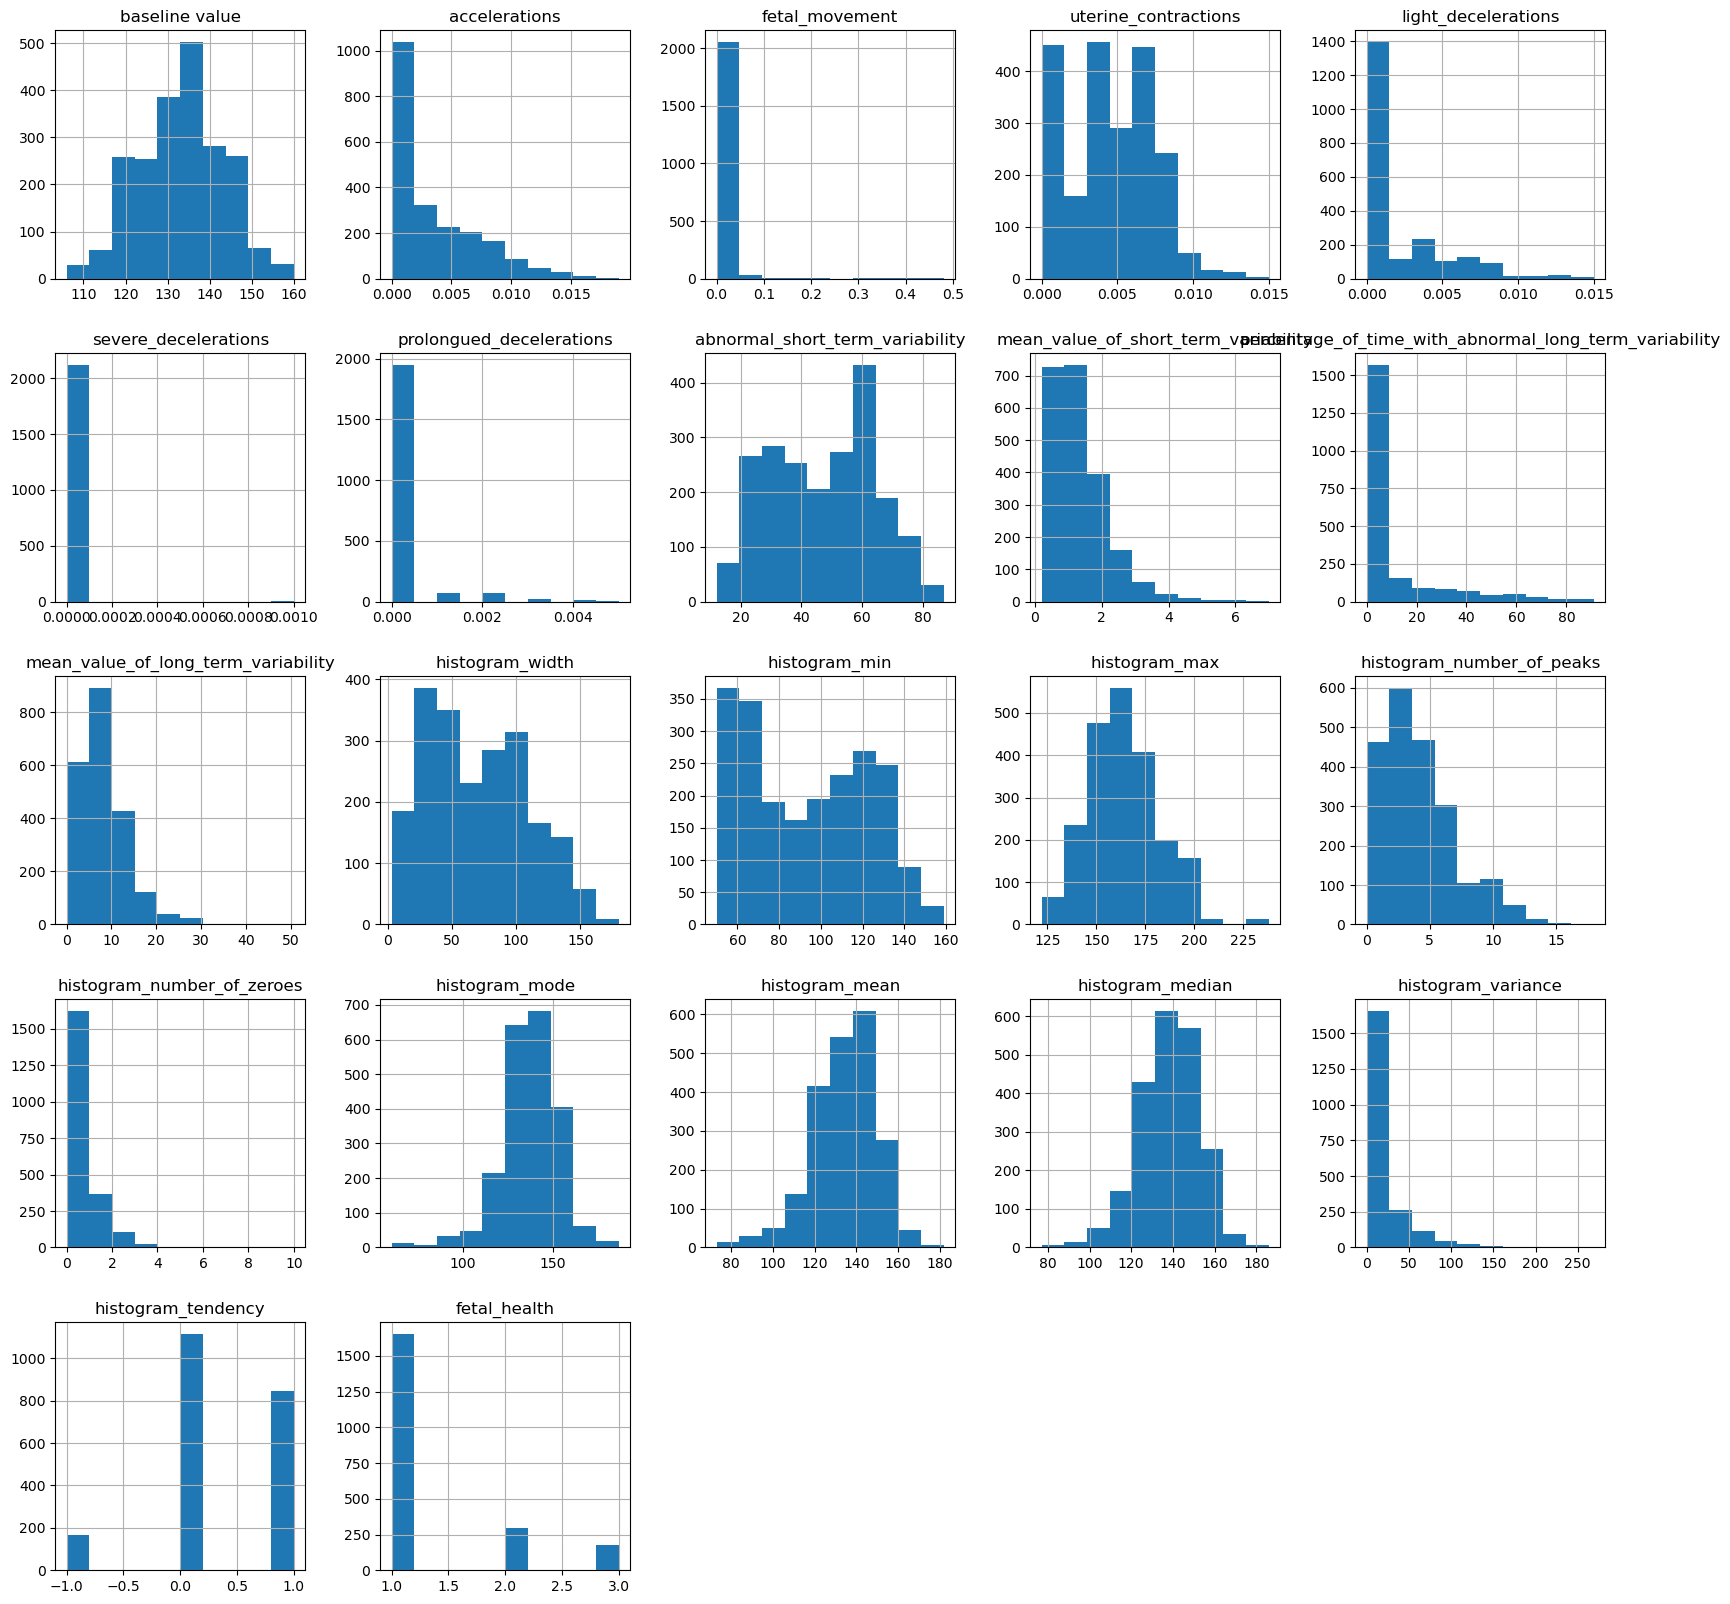

In [12]:
#As there are plenty of discrete and continuous data in this dataset, we use histogram to visualise
dataset_hist_plot = dataset.hist(figsize = (20,20))

<AxesSubplot:>

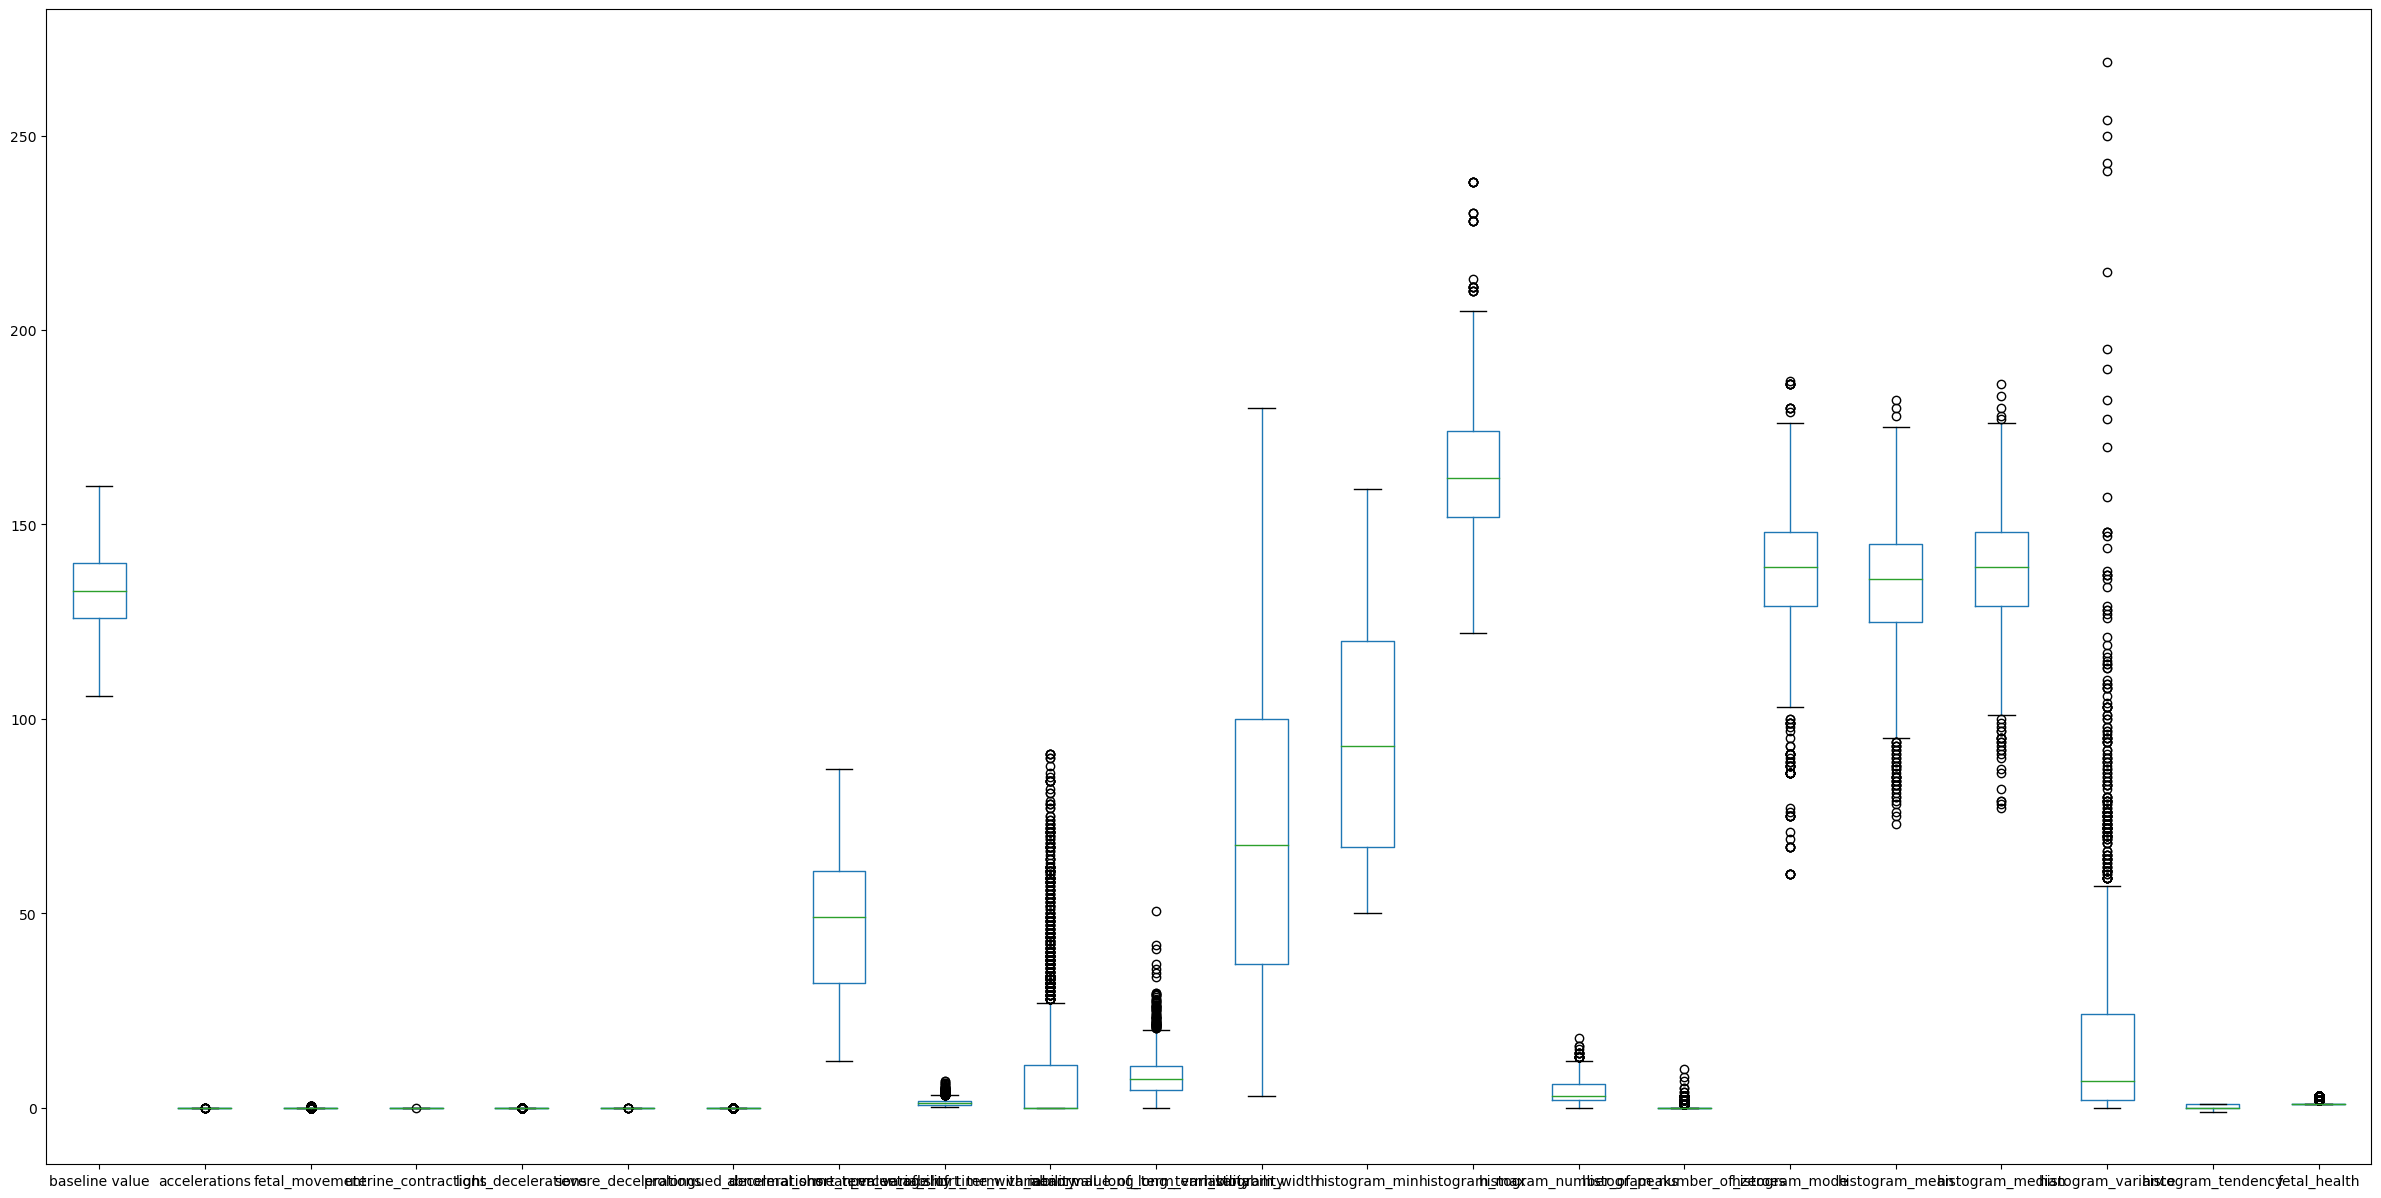

In [13]:
#Check for outliers with Boxplot
dataset.boxplot(figsize=(30,15),grid=False)

<AxesSubplot:xlabel='abnormal_short_term_variability'>

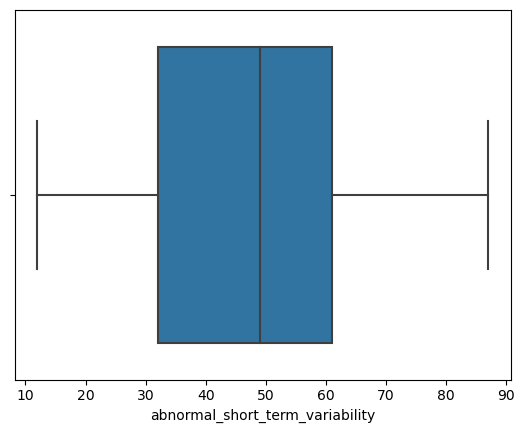

In [14]:
sns.boxplot(x=dataset["abnormal_short_term_variability"])

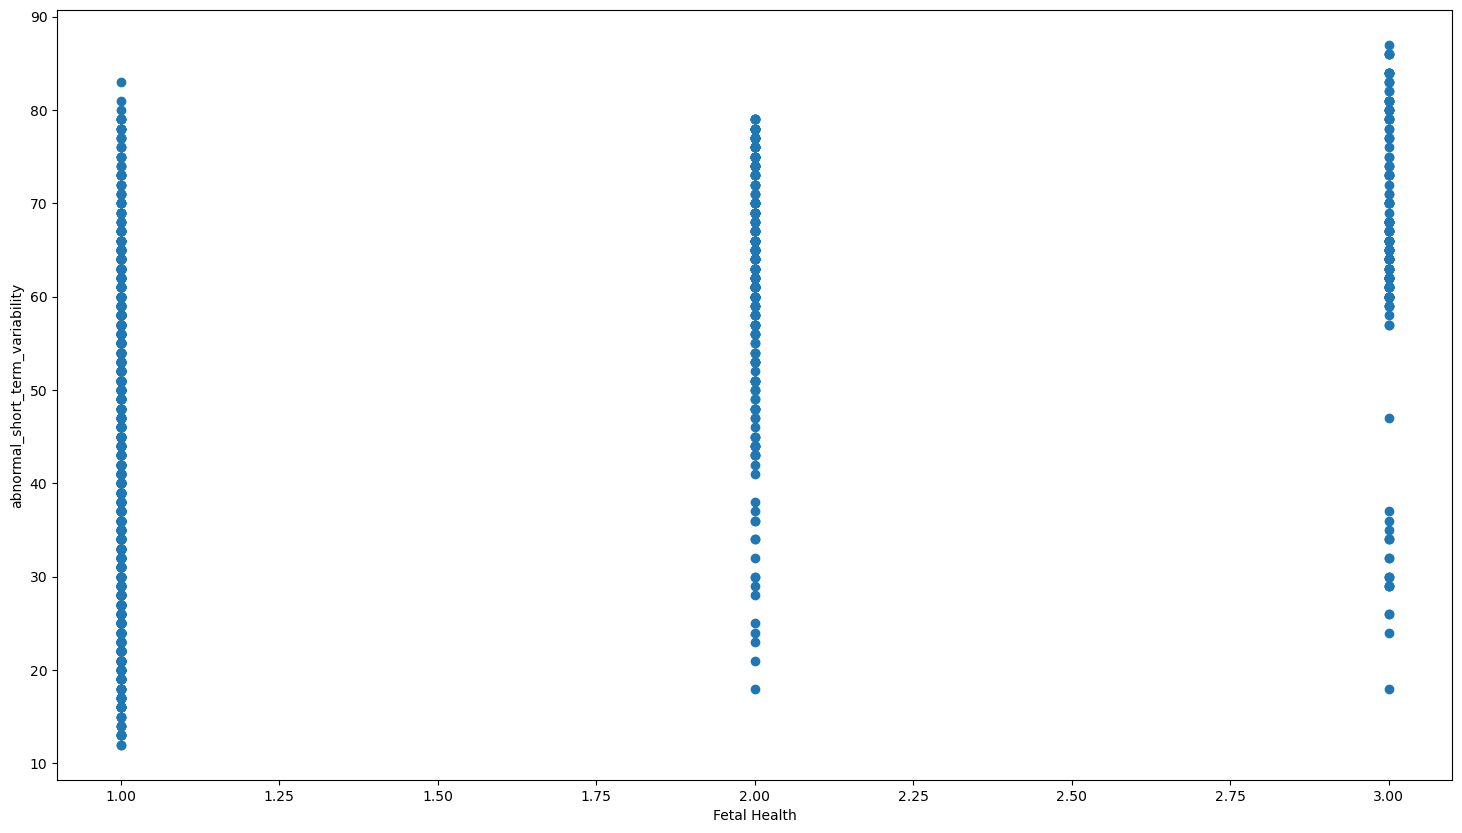

In [15]:
# Scatter plot
fig, ax = plt.subplots(figsize = (18,10))
ax.scatter(dataset['fetal_health'], dataset['abnormal_short_term_variability'])
 
# x-axis label
ax.set_xlabel('Fetal Health')
 
# y-axis label
ax.set_ylabel('abnormal_short_term_variability')
plt.show()

<AxesSubplot:xlabel='mean_value_of_short_term_variability'>

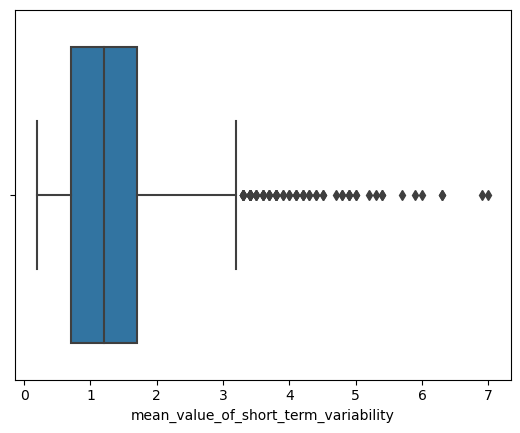

In [16]:
sns.boxplot(x=dataset["mean_value_of_short_term_variability"])

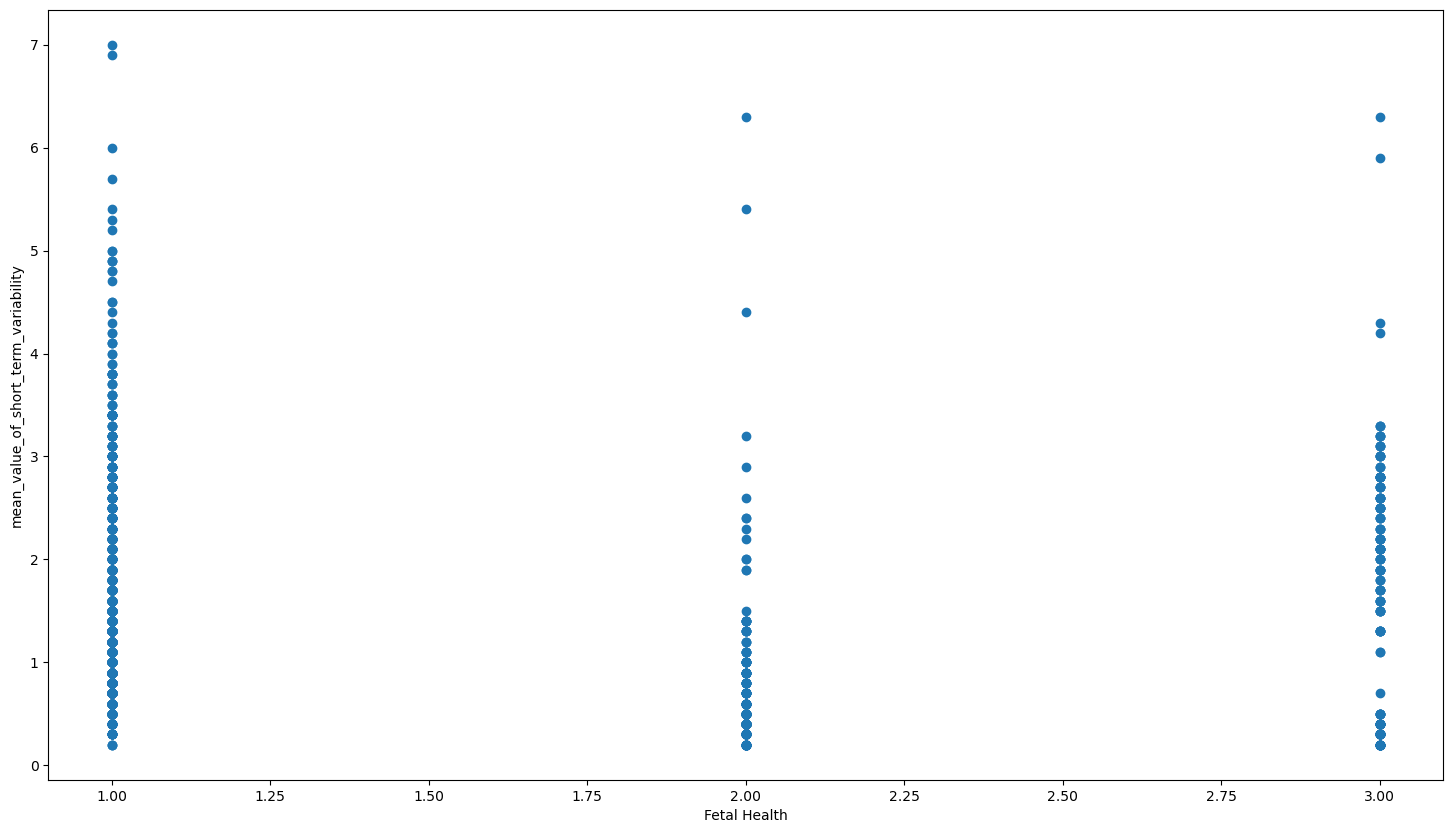

In [17]:
# Scatter plot
fig, ax = plt.subplots(figsize = (18,10))
ax.scatter(dataset['fetal_health'], dataset['mean_value_of_short_term_variability'])
 
# x-axis label
ax.set_xlabel('Fetal Health')
 
# y-axis label
ax.set_ylabel('mean_value_of_short_term_variability')
plt.show()

<AxesSubplot:xlabel='percentage_of_time_with_abnormal_long_term_variability'>

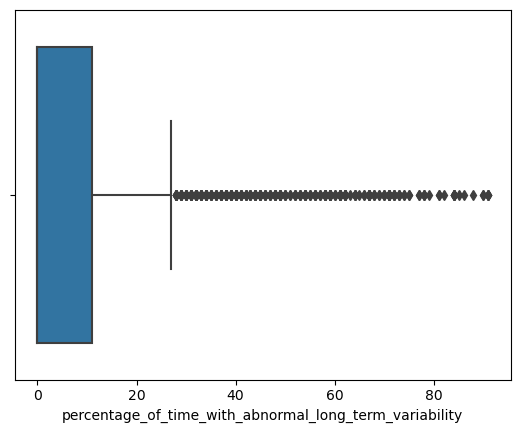

In [18]:
sns.boxplot(x=dataset["percentage_of_time_with_abnormal_long_term_variability"])

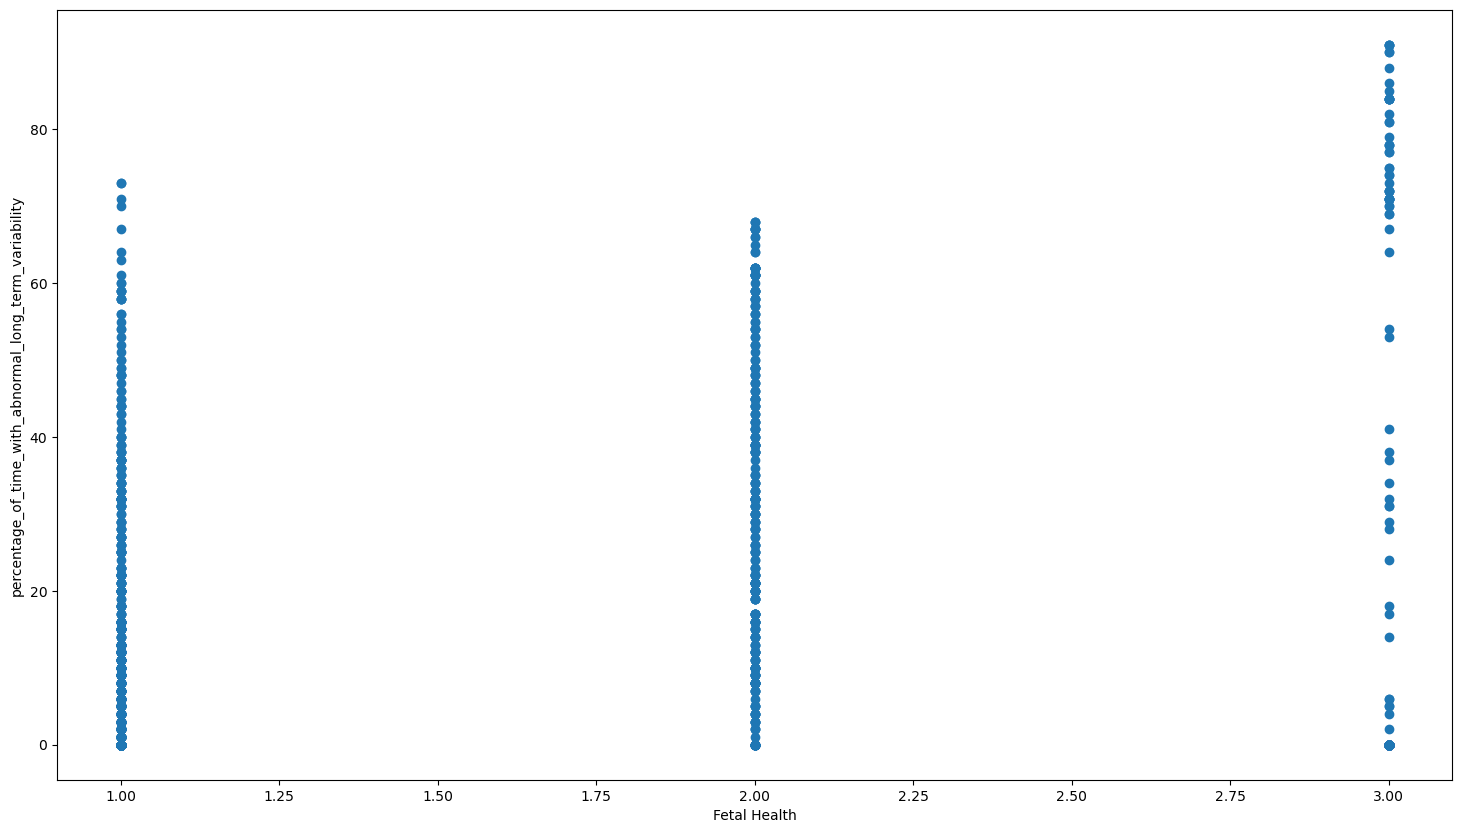

In [19]:
# Scatter plot
fig, ax = plt.subplots(figsize = (18,10))
ax.scatter(dataset['fetal_health'], dataset['percentage_of_time_with_abnormal_long_term_variability'])
 
# x-axis label
ax.set_xlabel('Fetal Health')
 
# y-axis label
ax.set_ylabel('percentage_of_time_with_abnormal_long_term_variability')
plt.show()

<AxesSubplot:xlabel='histogram_min'>

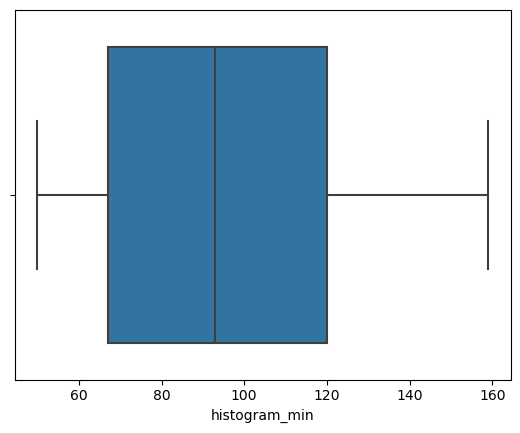

In [20]:
sns.boxplot(x=dataset["histogram_min"])

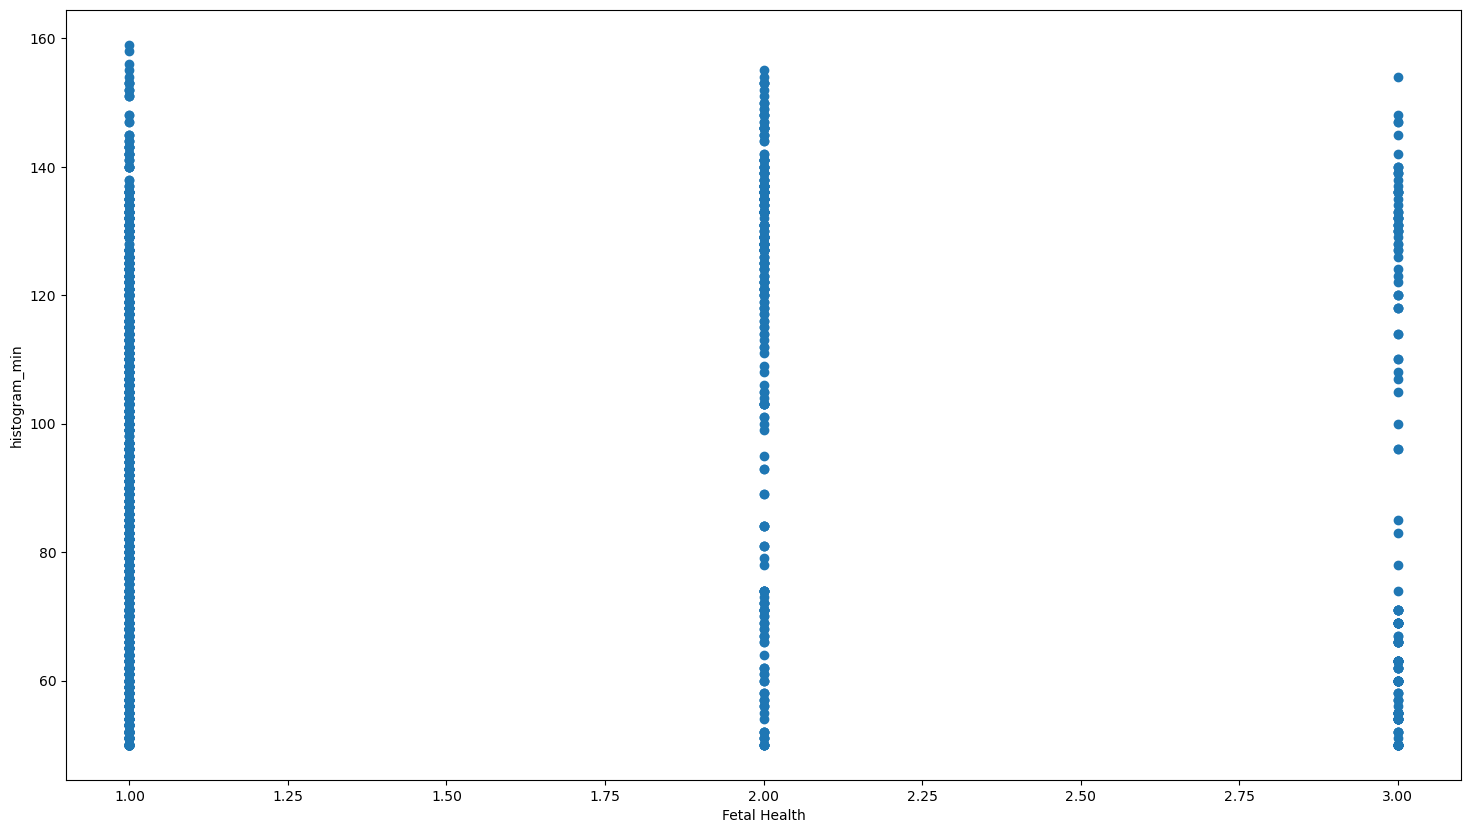

In [21]:
# Scatter plot
fig, ax = plt.subplots(figsize = (18,10))
ax.scatter(dataset['fetal_health'], dataset['histogram_min'])
 
# x-axis label
ax.set_xlabel('Fetal Health')
 
# y-axis label
ax.set_ylabel('histogram_min')
plt.show()

The graphs are skewed and there are outliers clearly noticeable. It may not be a good idea removing these outliers since the statistics are genuine figures provided by CTG, eliminating possibility of administrative error and important information regarding fetus health. Hence, the outliers remains.

# Data Cleaning

In [22]:
#Convert positive as 1 and negative as 0
dataset['fetal_health'].replace({1:'Normal',2.0:'Suspect',3.0:'Pathelogical'},inplace=True)

#Convert string to int (binary)
#1 - Normal, 2 - Suspect, 3 - Pathelogical
dataset['fetal_health'].replace({'Normal':1,'Suspect':2,'Pathelogical':3},inplace=True)

In [24]:
#Check if data type has been converted to int
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

fetal_health is currently a float value. As ML algorithm can only read integer values, data type is converted from float to int.

1 - Normal
2 - Suspect
3 - Pathological

# Splitting dataset into Train and Test sets

In [25]:
#Defining the input and output attributes for train and test sets
X = dataset.drop(['fetal_health'], axis=1)
y = dataset['fetal_health']

X - Independent Variables. All 21 variables except fetal_health will be under X. 

y - Dependent Variable. We want fetal_health outcome hence, it will be our output.

In [26]:
#Train 80%, Test 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=30)

#Train 70%, Test 30%
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=30)

#Train 60%, Test 40%
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,random_state=30)

Several train and test sizes are tested. 80% training, 20% testing with a random_state of 30 gives a better result in my analysis.

In [29]:
#Feature scaling to standardise data present in fixed range
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

Feature scaling is carried out while I was doing my train_test_split to standardise the data present in a fixed range

# Model Development

Three models are used – Random Forest, K-Nearest Neighbor (KNN) and SVM with their accuracies shown below.

# Random Forest 

It is an emsembled technique using several decision trees to narrow down to a single result

In [30]:
rnf = RandomForestClassifier()

#Create a Gaussian Clasifier
clf = RandomForestClassifier(n_estimators=100)

#Train the Model
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

Accuracy Score: 0.9342723004694836 

              precision    recall  f1-score   support

           1       0.95      0.98      0.96       330
           2       0.82      0.71      0.76        58
           3       0.97      0.89      0.93        38

    accuracy                           0.93       426
   macro avg       0.91      0.86      0.88       426
weighted avg       0.93      0.93      0.93       426



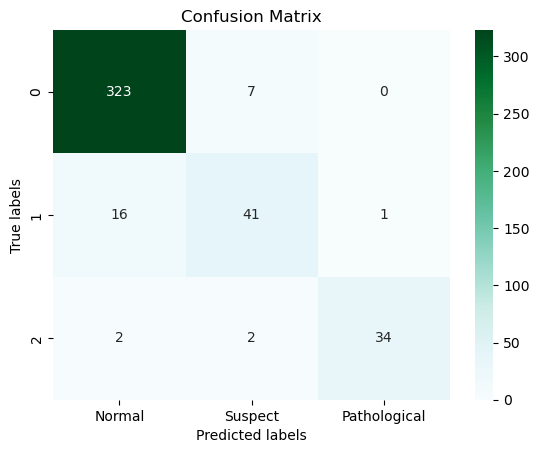

In [33]:
#Accuracy Score
print('Accuracy Score:', accuracy_score(y_test, y_pred),'\n')

#Classification Report Accuracy
print(classification_report(y_test, y_pred))

#Confusion Matrix
ax = plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, ax = ax, cmap = "BuGn", fmt='.4g');
# labels, title and ticks
ax.set_xlabel("Predicted labels");
ax.set_ylabel("True labels"); 
ax.set_title("Confusion Matrix"); 
ax.xaxis.set_ticklabels(["Normal", "Suspect", "Pathological"]);

True Positive - 
Normal: 2
Suspect: 41
Pathological: 0 

True Negative - 
Normal: 78
Suspect: 359
Pathological: 61

False Positive - 
Normal: 339
Suspect: 9
Pathological: 5

False Negative - 
Normal: 36
Suspect: 17
Pathological: 330

# KNN

KNN uses proximity to make classifications or predictions about the grouping of an individual data point.

In [37]:
#initialize the model
knn = KNeighborsClassifier(n_neighbors = 2, metric = 'manhattan')

#Fitting the data
knn.fit(X_train, y_train)

print('accuracy (Train):', knn.score(X_train, y_train))
print('accuracy (Test):', knn.score(X_test, y_test))

accuracy (Train): 0.9511764705882353
accuracy (Test): 0.8967136150234741


In [38]:
#Make the Predictions
y_pred = knn.predict(X_test)

In [39]:
#Accuracy Score
knn.score(X_test,y_test)

0.8967136150234741

In [40]:
#Finding the optimal k-value. I range k between 1-10
k_range = range(1, 11)

#Add the k-value to scores dictionary after fitting into the model
scores = []

#Use loop through the range 1 to 11 and add scores to the scores dictionary
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

print(scores)

[0.8990610328638498, 0.9014084507042254, 0.8967136150234741, 0.8896713615023474, 0.8967136150234741, 0.8873239436619719, 0.892018779342723, 0.8849765258215962, 0.8990610328638498, 0.8990610328638498]


Text(0, 0.5, 'Testing Accuracy')

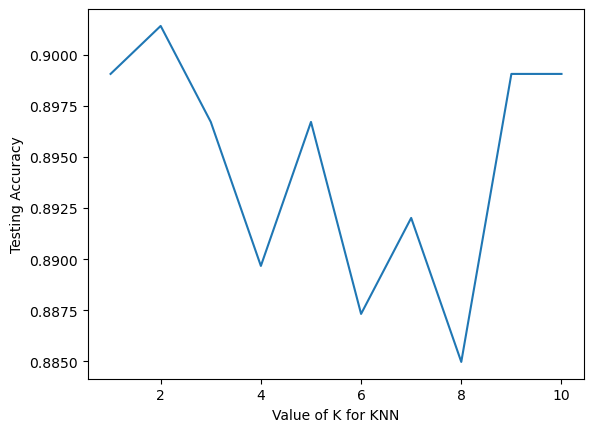

In [41]:
%matplotlib inline

# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [42]:
#List of K(s) to be tested
K = []

for i in range(2, 20):
  K.append(i)

#List of hyperparameters to test
parameters = {
    'n_neighbors': K,
    'metric' : ['euclidean', 'manhattan', 'minkowski'],
    'n_jobs': [-1]
}

#GridSearchCV
from sklearn.model_selection import GridSearchCV
GridSearch = GridSearchCV(estimator = KNeighborsClassifier(), param_grid=parameters, cv = 5)
GridSearch.fit(X_train, y_train)

#Display the best hyperparameters configuration tested
GridSearch.best_params_

{'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 2}

0.8990610328638498 

              precision    recall  f1-score   support

           1       0.91      0.98      0.94       330
           2       0.71      0.52      0.60        58
           3       1.00      0.79      0.88        38

    accuracy                           0.90       426
   macro avg       0.88      0.76      0.81       426
weighted avg       0.89      0.90      0.89       426



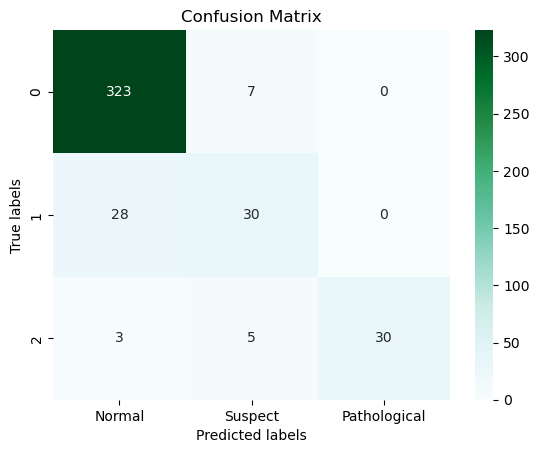

In [44]:
#Accuracy Score
print(accuracy_score(y_test, y_pred),'\n')

#Classification Report Accuracy
print(classification_report(y_test, y_pred))

#Confusion Matrix
ax = plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, ax = ax, cmap = "BuGn", fmt='.4g');
# labels, title and ticks
ax.set_xlabel("Predicted labels");
ax.set_ylabel("True labels"); 
ax.set_title("Confusion Matrix"); 
ax.xaxis.set_ticklabels(["Normal", "Suspect", "Pathological"]);

True Positive - 
Normal: 3
Suspect: 30
Pathological: 0

True Negative - 
Normal: 35
Suspect: 28
Pathological: 30

False Positive - 
Normal: 351
Suspect: 12
Pathological: 30

False Negative - 
Normal: 65
Suspect: 356
Pathological: 66

# SVM

Support Vector Machine (SVM) finds a hyperplane in a N-dimensional space (N referring to the number of features) to distinctly classifies the data point.

In [45]:
#Initialise Model
clf_SVC = SVC(kernel='linear')

#Fitting Data to Model
clf_SVC.fit(X_train, y_train)

#Prediction
y_pred = clf_SVC.predict(X_test)

0.9178403755868545 

              precision    recall  f1-score   support

           1       0.94      0.97      0.96       330
           2       0.75      0.72      0.74        58
           3       0.94      0.76      0.84        38

    accuracy                           0.92       426
   macro avg       0.88      0.82      0.84       426
weighted avg       0.92      0.92      0.92       426



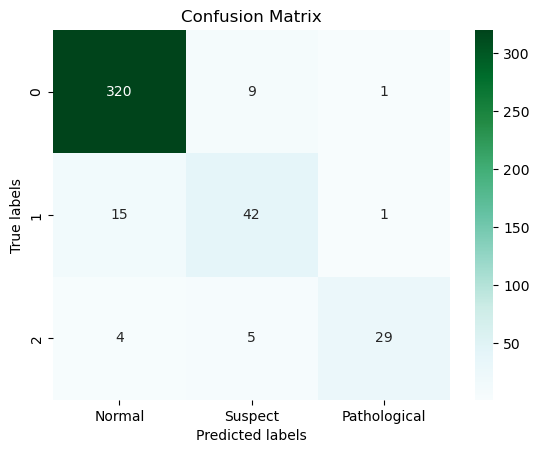

In [46]:
#Accuracy Score
print(accuracy_score(y_test, y_pred),'\n')

#Classification Report Accuracy
print(classification_report(y_test, y_pred))

#Confusion Matrix
ax = plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, ax = ax, cmap = "BuGn", fmt='.4g');
# labels, title and ticks
ax.set_xlabel("Predicted labels");
ax.set_ylabel("True labels"); 
ax.set_title("Confusion Matrix"); 
ax.xaxis.set_ticklabels(["Normal", "Suspect", "Pathological"]);

True Positive - 
Normal: 4
Suspect: 42
Pathological: 1

True Negative - 
Normal: 34
Suspect: 16
Pathological: 329 

False Positive - 
Normal: 335
Suspect: 14
Pathological: 30 

False Negative - 
Normal: 77
Suspect: 354
Pathological: 66

# Conclusion

Random Forest gives a better accuracy score but SVM might be a better model when supported with Confusion Matrix. We want to reduce the number of people who are wrongly tested as negative when they should be positive and are correctly tested as negative especially in a medical sector.